<a href="https://colab.research.google.com/github/gwohlgen/samples/blob/master/Spam_Detection_with_BERT_RoBERTa_and_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam detection with BERT and FastAI
1.   Inspired by [fastAI IMDB classifcation notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)
2.   But here we want to use BERT instead of AWD_LSTM as encoder
3.   For integration of BERT and FastAI we use this reference: https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2

4.   The data is about email **spam detection** -- the classes are "spam" and "ham"
5.   Steps we take: (a) download and understand the data, (b) finetune the language model (LM), (c) train the classifier, (d) Evaluate the classifier



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## (a) Downloading and Understanding / EDA of the data
1. The data is encoded in latin-1, we want to change it to utf-8
2. Get some statistics of the data
3. Visualize length of the text and its distribution

In [0]:
!wget https://raw.githubusercontent.com/gwohlgen/misc/master/spam.csv
!ls

--2020-04-25 20:13:56--  https://raw.githubusercontent.com/gwohlgen/misc/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.005s  

2020-04-25 20:13:57 (95.8 MB/s) - ‘spam.csv’ saved [503663/503663]

sample_data  spam.csv


In [0]:
## change file encoding from latin-1 to utf-8

import codecs
infile  = codecs.open('spam.csv', 'r', encoding='latin1')
outfile = codecs.open('spam-utf8.csv', 'w', encoding='utf-8')

list(map(outfile.write, infile))

infile.close()
outfile.close()
!head spam-utf8.csv

# ok, data in utf-8 format now


v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Clai

In [0]:
df = pd.read_csv('spam-utf8.csv')
df.head(10)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


Hmm, why do we have 5 columns, maybe there is a mistake?


In [0]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


There are 50 / 12 / 6 rows in the unnamed columns, probably a mistake in terms of input separators. All text should be in the second (v2) column, **we have to fix this**!


In [0]:
# show part of df where "Unnamed: 2" column has some text -- we want to merge all that into the "real" text column
df[df["Unnamed: 2"].notna()]
 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [0]:
# ok, we want to concat everything into the text column
# rename columns to something nicer
df.columns = ['label','text_orig','e1', 'e2','e3']


In [0]:
# let's try some ways to merge e1,e2,e3 into 'text'

# does this work? No, because of NaN
df['text'] = df['text_orig'] + df['e1'] + df['e2'] + df['e3']
print(df['text'].head())
print('\n\n')


# does this work? No, "nannannan" appended to the end
df['text'] = df['text_orig'] + df['e1'].astype(str) + df['e2'].astype(str) + df['e3'].astype(str)
print(df.head())
print(df.iloc[0,5])
print('\n\n')

# this is a solution -- na_rep is important in our case!
df["text"] = df["text_orig"].str.cat(df[['e1','e2','e3']], sep =" ", na_rep='')

# test on a few examples
print(df.iloc[0,5])   # e1, e2, e3 == NaN
print(df.iloc[95,5])  # e3 = NaN
print(df.iloc[281,5]) # all e1-e3 have text in them
print('\n\n')

# save the result into df_clean
df_clean = df[["label", "text"]]
df_clean.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: text, dtype: object



  label  ...                                               text
0   ham  ...  Go until jurong point, crazy.. Available only ...
1   ham  ...             Ok lar... Joking wif u oni...nannannan
2  spam  ...  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  ...  U dun say so early hor... U c already then say...
4   ham  ...  Nah I don't think he goes to usf, he lives aro...

[5 rows x 6 columns]
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...nannannan



Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...   
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML  PO Box 5249  MK17 92H. 450Ppw 16" 
\Wen u miss someone  the person is definitely special for u..... But if the person is so special  why to miss them  jus

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df_clean.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Ok, we have some **text duplicates** (5169 unique out of 5572), that's not too great, **let's remove them**


In [0]:
df_final = df_clean.drop_duplicates(subset="text", keep = 'first', inplace = False)
df_final.describe()

,label,text
count,5169,5169
unique,2,5169
top,ham,Enjoy urself tmr...
freq,4516,1


In [0]:
df_final.to_csv('spam_final.csv')
!head spam_final.csv


,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...   "
1,ham,Ok lar... Joking wif u oni...   
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's   
3,ham,U dun say so early hor... U c already then say...   
4,ham,"Nah I don't think he goes to usf, he lives around here though   "
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv   "
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.   
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune   
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim c

**Dataset cleanup finished .. this is often one of the most time-intense steps**

Let's continue with some more EDA



In [0]:
text_length = df_final['text'].str.len()
text_length.describe()

count    5169.000000
mean       82.527762
std        58.467143
min         5.000000
25%        39.000000
50%        64.000000
75%       122.000000
max       913.000000
Name: text, dtype: float64

text_lengh.describe() shows us, that the avg text lenght is only 82 chars, so we have rather **short texts** to classify, typically one or 2 sentences. 
Below we want to visualize text_length of our documents.

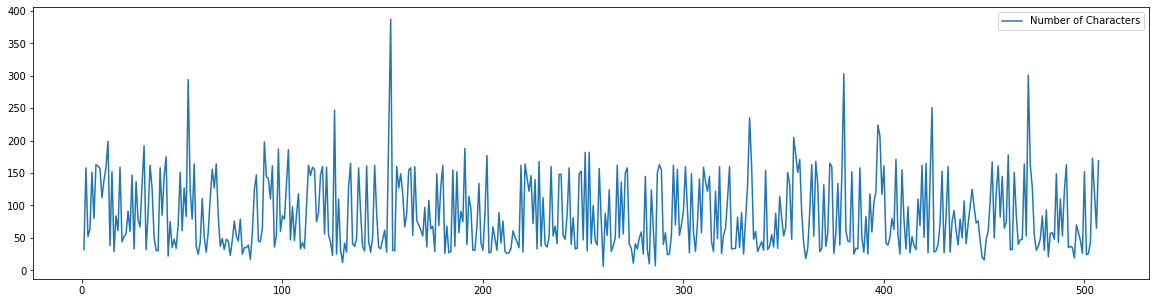

In [0]:
# plot length of first 500 texts
plt.figure()
text_length.iloc[1:500].plot(label='Number of Characters', figsize=(20, 5))
plt.legend(loc='best')

It's interesting that we have 2 peaks, one peak with documents around 35 chars long, and one around 150 chars  


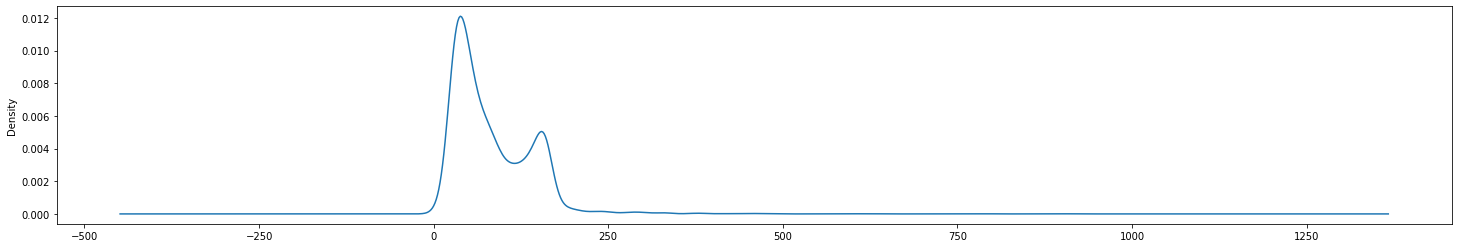

In [0]:
# density plot
text_length.plot(kind='kde', figsize=(25,4))
print("It's interesting that we have 2 peaks, one peak with documents around 35 chars long, and one around 150 chars  ")


## (b) Language model fine-tuning with BERT


*Note* that language models can use a lot of GPU, so you may need to decrease batchsize here.

**OK, before we can start LM finetuning with, we need to take some steps according to:  https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?gi=2edde57acf8b**

** Huggingface transformers are found here: https://github.com/huggingface/transformers**


In [0]:
# install the huggingface transformer package (which supports BERT, albERT, XL-NET, GPT and other transformer-based architectures)
!pip install transformers


     |████████████████████████████████| 573kB 44.8MB/s 
     |████████████████████████████████| 1.0MB 52.6MB/s 
     |████████████████████████████████| 3.7MB 50.7MB/s 
     |████████████████████████████████| 890kB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=6cffcad735ef74b5387849068d0011f25b1ab3317f927a1182729a35c9be6a53
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


**We need 3 parts per model:**

  * SequenceClassification object
  * Tokenizer (different models need slightly different tokenizers)
  * Config

In [0]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
    


In [0]:
# ** important ** -- set the model architecture to use!
model_type = 'roberta'
model_name = 'roberta-base'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

** first we need to overwrite the fastAI tokenizer -- as the transformers need a different way of tokenization**

In [0]:
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

** We also need a custom numericalizer**, which does the itos and stoi mapping.

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


Now we can create the **custom processor** which can be used by the fastAI databunch.

In [0]:
# initialize tokenizer and numericalizer
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
# only xlnet needs padding at the beginning
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id


**Create the fastAI databunch**

* use our custom processor (for tokenization and numericalisation)
* rest is pretty standard

In [0]:
bs=48
databunch = (TextList.from_csv(".", 'spam_final.csv', cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.2, seed=42)
             .label_from_df(cols=1)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [0]:
databunch.show_batch()

text,target
<s> ĠHow Ġto ĠMake Ġa Ġgirl ĠHappy ? ĠIt 's Ġnot Ġat Ġall Ġdifficult Ġto Ġmake Ġgirls Ġhappy . ĠU Ġonly Ġneed Ġto Ġbe ... Ġ1 . ĠA Ġfriend Ġ2 . ĠCompanion Ġ3 . ĠLover Ġ4 . ĠChef Ġ. Ġ. Ġ. Ġ Ġ& lt ; # & gt ; Ġ. ĠGood Ġlistener Ġ Ġ& lt ; # & gt ; Ġ. ĠOrgan izer Ġ Ġ& lt ; # & gt,ham
<s> ĠFor Ġme Ġthe Ġlove Ġshould Ġstart Ġwith Ġattraction . i Ġshould Ġfeel Ġthat ĠI Ġneed Ġher Ġevery Ġtime Ġaround Ġme . she Ġshould Ġbe Ġthe Ġfirst Ġthing Ġwhich Ġcomes Ġin Ġmy Ġthoughts . I Ġwould Ġstart Ġthe Ġday Ġand Ġend Ġit Ġwith Ġher . she Ġshould Ġbe Ġthere Ġevery Ġtime ĠI Ġdream . love Ġwill Ġbe Ġthen Ġwhen Ġmy Ġevery Ġbreath Ġhas Ġher Ġname . my Ġlife Ġshould Ġhappen,ham
"<s> ĠIndians Ġr Ġpoor Ġbut ĠIndia Ġis Ġnot Ġa Ġpoor Ġcountry . ĠSays Ġone Ġof Ġthe Ġsw iss Ġbank Ġdirectors . ĠHe Ġsays Ġthat Ġ\ Ġ& lt ; # & gt ; Ġ Ġlac Ġcrore \"" Ġof ĠIndian Ġmoney Ġis Ġdeposited Ġin Ġsw iss Ġbanks Ġwhich Ġcan Ġbe Ġused Ġfor Ġ' tax less ' Ġbudget Ġfor Ġ Ġ& lt ; # & gt ; Ġ Ġy rs . ĠCan Ġgive",ham
"<s> ĠA ĠBoy Ġloved Ġa Ġgal . ĠHe Ġprops d Ġb t Ġshe Ġdidnt Ġmind . ĠHe Ġg v Ġl v Ġl tt rs , ĠB t Ġher Ġfr nd s Ġthrew Ġth m . ĠAgain Ġd Ġboy Ġdecided Ġ2 Ġa pro ach Ġd Ġgal Ġ, Ġd t Ġtime Ġa Ġtruck Ġwas Ġspeeding Ġtowards Ġd Ġgal . ĠW n Ġit Ġwas Ġabout Ġ2 Ġhit Ġd Ġgirl , d Ġboy Ġran",ham
"<s> ĠStorm ing Ġmsg : ĠWen Ġu Ġlift Ġd Ġph ne , Ġu Ġsay Ġ\ HE LL O \"" ĠDo Ġu Ġkn w Ġw t Ġis Ġd Ġreal Ġmeaning Ġof ĠHELL O ?? Ġ. Ġ. Ġ. ĠIt 's Ġd Ġname Ġof Ġa Ġgirl .. ! Ġ. Ġ. Ġ. ĠYes .. ĠAnd Ġu Ġkn w Ġwho Ġis Ġdat Ġgirl ?? Ġ\"" Marg aret ĠHello \"" ĠShe Ġis Ġd Ġg irlf r",ham


**Remark:** I wonder where that "Ġ" is coming from. 

TODO: find out if this is normal.

Quick check: maybe ByteLevelBPETokenizer creates this?

---
Next, we need that a nn.Module with a forward method that returns the logits from the transformer forward() method

In [0]:

class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

**Get the pretrained model** do some config, and **init the transformer model** 

In [0]:
config = config_class.from_pretrained(model_name)
config.num_labels = 2

transformer_model = model_class.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)


**Create the learner object**, with AdamW optimizer

In [0]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy])

In [0]:
print(learner.model)


CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

**For discriminative learning rates we need to define the list of layers for fastAI!** -- based on the model above

In [0]:
list_layers = [learner.model.transformer.roberta.embeddings,
               learner.model.transformer.roberta.encoder.layer[0], 
               learner.model.transformer.roberta.encoder.layer[1], 
               learner.model.transformer.roberta.encoder.layer[2], 
               learner.model.transformer.roberta.encoder.layer[3], 
               learner.model.transformer.roberta.encoder.layer[4], 
               learner.model.transformer.roberta.encoder.layer[5], 
               learner.model.transformer.roberta.encoder.layer[6], 
               learner.model.transformer.roberta.encoder.layer[7], 
               learner.model.transformer.roberta.encoder.layer[8], 
               learner.model.transformer.roberta.encoder.layer[9], 
               learner.model.transformer.roberta.encoder.layer[10], 
               learner.model.transformer.roberta.encoder.layer[11], 
               learner.model.transformer.classifier]

# split for descriminative LRs               
learner.split(list_layers)

Learner(data=TextClasDataBunch;

Train: LabelList (4136 items)
x: TextList
<s> ĠGo Ġuntil Ġjur ong Ġpoint , Ġcrazy .. ĠAvailable Ġonly Ġin Ġbug is Ġn Ġgreat Ġworld Ġla Ġe Ġbuffet ... ĠC ine Ġthere Ġgot Ġam ore Ġwat ... </s>,<s> ĠOk Ġlar ... ĠJ oking Ġw if Ġu Ġon i ... </s>,<s> ĠFree Ġentry Ġin Ġ2 Ġa Ġw k ly Ġcomp Ġto Ġwin ĠFA ĠCup Ġfinal Ġt k ts Ġ21 st ĠMay Ġ2005 . ĠText ĠFA Ġto Ġ87 121 Ġto Ġreceive Ġentry Ġquestion ( std Ġt xt Ġrate ) T & C 's Ġapply Ġ08 45 28 100 75 over 18 's </s>,<s> ĠU Ġdun Ġsay Ġso Ġearly Ġhor ... ĠU Ġc Ġalready Ġthen Ġsay ... </s>,<s> ĠNah ĠI Ġdon 't Ġthink Ġhe Ġgoes Ġto Ġus f , Ġhe Ġlives Ġaround Ġhere Ġthough </s>
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1033 items)
x: TextList
<s> ĠDid Ġu Ġdownload Ġthe Ġfr ing Ġapp ? </s>,<s> ĠPass Ġdis Ġto Ġall Ġur Ġcontacts Ġn Ġsee Ġwat Ġu Ġget ! ĠRed ; i 'm Ġin Ġl uv Ġwid Ġu . ĠBlue ; u Ġput Ġa Ġsmile Ġon Ġmy Ġface . ĠPurple ; u Ġr Ġreal y Ġhot . ĠPink ; u Ġr Ġso Ġsw t . ĠOrange ; i Ġth n k Ġi Ġly 

**Now do the usual fastAI training**

In [0]:
learner.freeze_to(-1)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


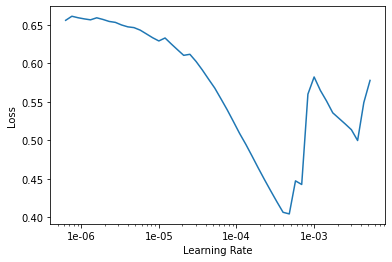

In [0]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [0]:
learner.fit_one_cycle(3,max_lr=2e-03,moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.121487,0.140632,0.964182,00:10
1,0.105854,0.104195,0.971926,00:11


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


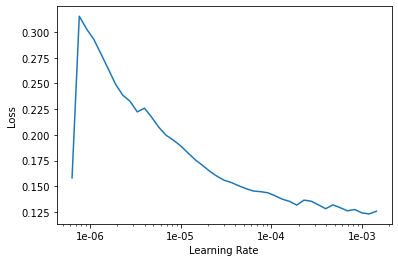

In [0]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [0]:
num_groups = 14 # number of layers?! (wohlg: my interpretation)

In [0]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


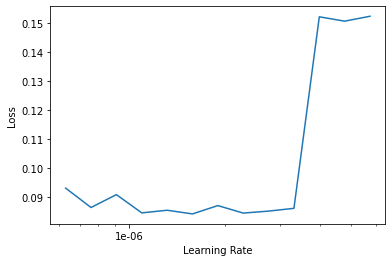

In [0]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [0]:
lr = 1e-6
learner.fit_one_cycle(1, 
                      max_lr=slice(lr*0.95**num_groups, lr), 
                      moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.072482,0.089498,0.971926,00:11


In [0]:
learner.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


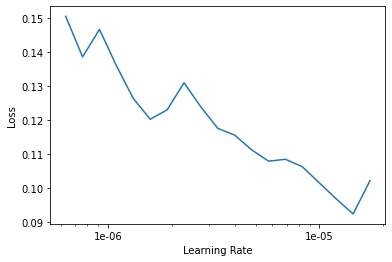

In [0]:
learner.freeze_to(-3)
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [0]:
lr = 2e-6
learner.fit_one_cycle(1, 
                      max_lr=slice(lr*0.95**num_groups, lr), 
                      moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.088233,0.084210,0.972894,00:14


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


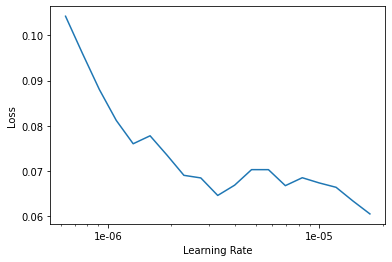

In [0]:
learner.freeze_to(-6)
learner.lr_find()
learner.recorder.plot()


In [0]:
learner.load('stage-3')

Learner(data=TextClasDataBunch;

Train: LabelList (4136 items)
x: TextList
<s> ĠGo Ġuntil Ġjur ong Ġpoint , Ġcrazy .. ĠAvailable Ġonly Ġin Ġbug is Ġn Ġgreat Ġworld Ġla Ġe Ġbuffet ... ĠC ine Ġthere Ġgot Ġam ore Ġwat ... </s>,<s> ĠOk Ġlar ... ĠJ oking Ġw if Ġu Ġon i ... </s>,<s> ĠFree Ġentry Ġin Ġ2 Ġa Ġw k ly Ġcomp Ġto Ġwin ĠFA ĠCup Ġfinal Ġt k ts Ġ21 st ĠMay Ġ2005 . ĠText ĠFA Ġto Ġ87 121 Ġto Ġreceive Ġentry Ġquestion ( std Ġt xt Ġrate ) T & C 's Ġapply Ġ08 45 28 100 75 over 18 's </s>,<s> ĠU Ġdun Ġsay Ġso Ġearly Ġhor ... ĠU Ġc Ġalready Ġthen Ġsay ... </s>,<s> ĠNah ĠI Ġdon 't Ġthink Ġhe Ġgoes Ġto Ġus f , Ġhe Ġlives Ġaround Ġhere Ġthough </s>
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1033 items)
x: TextList
<s> ĠDid Ġu Ġdownload Ġthe Ġfr ing Ġapp ? </s>,<s> ĠPass Ġdis Ġto Ġall Ġur Ġcontacts Ġn Ġsee Ġwat Ġu Ġget ! ĠRed ; i 'm Ġin Ġl uv Ġwid Ġu . ĠBlue ; u Ġput Ġa Ġsmile Ġon Ġmy Ġface . ĠPurple ; u Ġr Ġreal y Ġhot . ĠPink ; u Ġr Ġso Ġsw t . ĠOrange ; i Ġth n k Ġi Ġly 

In [0]:
lr = 2e-6
learner.fit_one_cycle(1, 
                      max_lr=slice(lr*0.95**num_groups, lr), 
                      moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.070693,0.042986,0.988383,00:19


In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


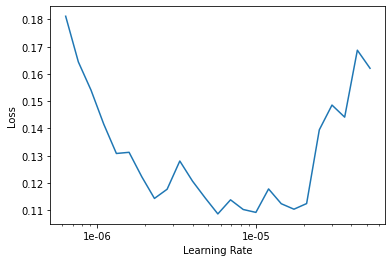

In [0]:
learner.freeze_to(-6)
learner.lr_find()
learner.recorder.plot()

In [0]:
lr = 2e-6
learner.fit_one_cycle(5, 
                      max_lr=slice(lr*0.95**num_groups, lr), 
                      moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.055987,0.046967,0.984511,00:18
1,0.047857,0.051084,0.982575,00:19
2,0.040417,0.033085,0.988383,00:21
3,0.039264,0.034747,0.989351,00:20
4,0.029626,0.037599,0.986447,00:19


In [0]:
learner.save("stage-unfrozen")


In [0]:
## train some more until overfitting
lr = 2e-6
learner.fit_one_cycle(10, 
                      max_lr=slice(lr*0.95**num_groups, lr), 
                      moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.022525,0.039468,0.986447,00:17
1,0.034557,0.031912,0.989351,00:20
2,0.037373,0.031676,0.990319,00:20
3,0.030245,0.031591,0.989351,00:21
4,0.027741,0.031911,0.990319,00:20
5,0.030094,0.040436,0.990319,00:21
6,0.021928,0.029954,0.989351,00:19
7,0.020858,0.029815,0.989351,00:21
8,0.023661,0.031879,0.988383,00:18
9,0.018098,0.031756,0.988383,00:19


In [0]:
## maybe there is bit of overfitting now :)

# Evaluation and Prediction

1. Do some example predications
2. Look at the confusion matrix

In [0]:
learner.predict("Free entry in 2 a wkly comp to win FA Cup final.")
# class 0 is ham, class 1 is spam. prediction looks wrong

(Category ham, tensor(0), tensor([0.8951, 0.1049]))

In [0]:
%%timeit
learner.predict("Free entry in 2 a wkly comp to win FA Cup final.")

100 loops, best of 3: 11.2 ms per loop


In [0]:
learner.predict("Let's meet tomorrow and discuss the project.")

(Category ham, tensor(0), tensor([9.9992e-01, 8.2211e-05]))

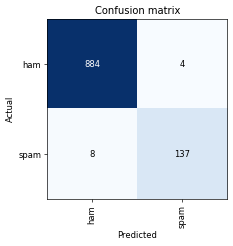

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

interp.plot_confusion_matrix(figsize=(4,4), dpi=60)